# Deep Fundamental Factor Models

#### Author: Matthew Dixon
#### Email: matthew.dixon@iit.edu
#### License: MIT license
#### Date: 10.13.2019
#### Citation: If you use this code for your research, please cite the following paper

##### Description

In [67]:
import csv
import pickle
import pandas as pd
import numpy as np
import re
import math
import random
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.regularizers import l1,l2
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
import os
#from utilities import *
#from view import *
import statsmodels.api as sm
#import datetime as dt
#from dateutil.relativedelta import *

# comment these if running python instead of ipython
#%load_ext autoreload
%matplotlib inline 
#%autoreload 1

In [4]:
# define neural network model in Keras
def NN(n_inputs, n_units = 30, dropout =0.1, l1_reg =0.001, activation='relu', L=2):
    # L>0 is the number of hidden layers
    
    model = Sequential()
    model.add(Dense(units=n_units, input_dim=n_inputs, kernel_regularizer=l1(l1_reg), kernel_initializer='normal', activation=activation))
    model.add(Dropout(dropout))
    for i in range (0,L-1):
        model.add(Dense(units=n_units, kernel_regularizer=l1(l1_reg), kernel_initializer='normal', activation=activation))
        model.add(Dropout(dropout))
    model.add(Dense(1, kernel_initializer='normal')) 
    model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mae'])
    return(model)

In [5]:
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=3)

In [6]:
"""
 NN parameter tuning:
"""
def parameter_tuning(X, y, cv=3, seed = 7):


   param_grid = dict(n_inputs=[X.shape[1]],n_units=[50,100,200], l1_reg = [0, 0.0001, 0.001,0.01], activation=['relu','tanh']) # dropout=[0, 0.1, 0.2, 0.3],  #n_hidden_neurons=[10,50,100], 
   estimator = KerasRegressor(build_fn=NN, epochs=100, batch_size=50, verbose=0)   
   grid = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=cv,fit_params=dict(callbacks=[es]))
   grid_result = grid.fit(X, y)
 
   print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
   means = grid_result.cv_results_['mean_test_score']
   stds = grid_result.cv_results_['std_test_score']
   params = grid_result.cv_results_['params']
   for mean, stdev, param in zip(means, stds, params):
         print("%f (%f) with: %r" % (mean, stdev, param))

In [69]:
def training_PLS(XTRAIN, YTRAIN, XTEST, YTEST, L):
 
    n_epoches = 100  # maximum number of epoches (to be used with early stopping)
    n_batch = 50     # mini-batch size
    drop_out = 0.0   # level of dropout (set between 0 and 1)
    n_units = 100
    l1_reg = 0.00  # L_1 regularization parameter
    tune = False     # set to true to perform cross-validation for parameter tuning
    activation='relu'
    models = {}
    xs = {}
    ys = {}
    
    models = {}
    models['linear']=[]
    models['NN']=[]
    xs = {}
    ys = {}

    xs['train']=[]
    xs['test']=[]
    ys['train']=[]
    ys['test']=[]
    
    betas = {}
    betas['NN'] =[]
    betas['linear'] =[]

    #start_time = timeit.default_timer()
    
    for i in range(len(XTRAIN)):
        x_train_file = "data/PLS_data/x_train/%s" % (XTRAIN[i])
        y_train_file = "data/PLS_data/y_train/%s" % (YTRAIN[i])
        x_test_file = "data/PLS_data/x_test/%s" % (XTEST[i])
        y_test_file = "data/PLS_data/y_test/%s" % (YTEST[i])
        
        x_train = pd.read_csv(x_train_file)
        y_train = pd.read_csv(y_train_file)
        x_test = pd.read_csv(x_test_file)
        y_test = pd.read_csv(y_test_file)
        
        x_train.drop(columns='Unnamed: 0', inplace=True)
        y_train.drop(columns='Unnamed: 0', inplace=True)
        x_test.drop(columns='Unnamed: 0', inplace=True)
        y_test.drop(columns='Unnamed: 0', inplace=True)
        
        n_inputs = x_train.shape[1]
        if n_inputs ==0:
            next

        if tune:
            print("cross-validation...")
            parameter_tuning(x_train, y_train, 3)
            tune=False

        model = NN(n_units=n_units, n_inputs=n_inputs, dropout=drop_out, l1_reg=l1_reg, activation=activation, L=L)
        model.fit(x_train.values, y_train.values, epochs=n_epoches, batch_size=n_batch, verbose=0, callbacks=[es])   
        beta=sensitivities(model, x_train.values, L, activation)   
        models['NN'].append(model)
        betas['NN'].append(beta)

        x=sm.add_constant(x_train)

        model =sm.OLS(y_train, x).fit()   
        betas['linear'].append(model.params)
        models['linear'].append(model)
        xs['train'].append(x_train)
        xs['test'].append(x_test)
        ys['train'].append(y_train)
        ys['test'].append(y_test)

        #elapsed = timeit.default_timer() - start_time
        #print("Elapsed time:" + str(elapsed) + " (s)")
    

    return models, betas, xs, ys

In [8]:
# Compute the sensitivites of the network for either tanh or ReLU
def sensitivities(lm, X, L, activation='tanh'):
    
    W=lm.get_weights()
    M = np.shape(X)[0]
    p = np.shape(X)[1]
    beta=np.array([0]*M*(p+1), dtype='float32').reshape(M,p+1)
    B_0 =W[1]
    for i in range (0,L):
      if activation=='tanh':  
        B_0 = (np.dot(np.transpose(W[2*(i+1)]),np.tanh(B_0))+W[2*(i+1)+1])
      elif activation=='relu':
        B_0 = (np.dot(np.transpose(W[2*(i+1)]),np.maximum(B_0,0))+W[2*(i+1)+1])
    
          
    beta[:,0]= B_0 # intercept \beta_0= F_{W,b}(0)
    for i in range(M):
      I1 = np.dot(np.transpose(W[0]),np.transpose(X[i,])) + W[1]
      if activation=='tanh':
          Z= np.tanh(I1)  
          D = np.diag(1-Z**2)
      elif activation=='relu':
          Z=np.maximum(I1,0)
          D = np.diag(np.sign(Z)) 
               
      for j in range(p):
        J = np.dot(D,W[0][j])       
        for a in range (1,L):
          I= np.dot(np.transpose(W[2*a]),Z) + W[2*a+1] 
          if activation=='tanh':  
              Z = np.tanh(I)
              D = np.diag(1-Z**2)
          elif activation=='relu':    
              Z=np.maximum(I,0)
              D = np.diag(np.sign(Z)) 
          J = np.dot(np.dot(D,np.transpose(W[a*2])),J)
        beta[i,j+1]=np.dot(np.transpose(W[2*L]),J)
            
    return(beta)

In [85]:
# Load the data
X=pd.read_csv('../data/X.csv')
Y=pd.read_csv('../data/Y.csv')

In [35]:
XTRAIN = os.listdir('../data/PLS_data/x_train')
YTRAIN = os.listdir('../data/PLS_data/y_train')
XTEST = os.listdir('../data/PLS_data/x_test')
YTEST = os.listdir('../data/PLS_data/y_test')

## Training of models 

In [42]:
training_periods = 20
L = 2
models, betas, xs, ys = training_PLS(XTRAIN, YTRAIN, XTEST, YTEST, L)

Epoch 00037: early stopping
Epoch 00053: early stopping
Epoch 00046: early stopping
Epoch 00017: early stopping
Epoch 00027: early stopping
Epoch 00032: early stopping
Epoch 00048: early stopping
Epoch 00025: early stopping
Epoch 00042: early stopping
Epoch 00036: early stopping
Epoch 00040: early stopping
Epoch 00038: early stopping
Epoch 00044: early stopping
Epoch 00030: early stopping
Epoch 00042: early stopping
Epoch 00048: early stopping
Epoch 00019: early stopping
Epoch 00031: early stopping
Epoch 00031: early stopping
Epoch 00035: early stopping


In [111]:
training_periods = 20 # number of model training and evaluation periods
Y.dropna(inplace=True)
dates = Y.drop_duplicates('date')
dates = list(dates['date'][0:training_periods]) 

['1989-12-01',
 '1990-01-01',
 '1990-02-01',
 '1990-03-01',
 '1990-04-01',
 '1990-05-01',
 '1990-06-01',
 '1990-07-01',
 '1990-08-01',
 '1990-09-01',
 '1990-10-01',
 '1990-11-01',
 '1990-12-01',
 '1991-01-01',
 '1991-02-01',
 '1991-03-01',
 '1991-04-01',
 '1991-05-01',
 '1991-06-01',
 '1991-07-01']

In [123]:
len(dates)

20

In [ ]:
#pickle.dump(betas, open('betas', 'wb'))
#pickle.dump(models, open('models', 'wb'))
#pickle.dump(xs, open('xs', 'wb'))
#pickle.dump(ys, open('ys', 'wb'))

# Performance evaluation

In [48]:
testing_periods=training_periods-1
print(testing_periods)

19


In [ ]:
#MSEs linear

In [49]:
MSE = 0
y_hat_linear = []
MSE_array_linear=np.array([0]*training_periods,dtype='float64')
for i in range(testing_periods):
    x= sm.add_constant(xs['test'][i].values)
    y_hat_linear.append(models['linear'][i].predict(x))
    MSE_test_linear= mean_squared_error(y_hat_linear[-1], ys['test'][i].values)
    #print(i,MSE_test_linear)
    MSE_array_linear[i]=MSE_test_linear
    MSE+=MSE_test_linear
print("MSE:" + str(MSE/testing_periods))   
MSE_linear=MSE/testing_periods

MSE:0.021783873516808563


In [ ]:
# L_inf linear

In [50]:
L_inf = 0
y_hat_linear = []
L_inf_array_linear=np.array([0]*training_periods,dtype='float64')
for i in range(testing_periods):
    x= sm.add_constant(xs['test'][i].values)
    y_hat_linear.append(models['linear'][i].predict(x))
    L_inf_test_linear= np.max(np.abs(np.array(y_hat_linear[-1]- ys['test'][i].values)))
    #print(i,MSE_test_linear)
    L_inf_array_linear[i]=L_inf_test_linear
    L_inf+=L_inf_test_linear
print("L_inf:" + str(L_inf/testing_periods))
L_inf_linear=L_inf/testing_periods

L_inf:1.5090930308943602


In [ ]:
# MSEs linear (training)

In [51]:
MSE = 0
MSE_array_linear_in=np.array([0]*training_periods,dtype='float64')
y_hat_linear_is =[]
for i in range(training_periods):
    x= sm.add_constant(xs['train'][i].values)
    y_hat_linear_is.append(models['linear'][i].predict(x))
    MSE_test_linear= mean_squared_error(y_hat_linear_is[-1], ys['train'][i].values)
    #print(i,MSE_test_linear)
    MSE_array_linear_in[i]=MSE_test_linear
    MSE+=MSE_test_linear
print("MSE:" + str(MSE/training_periods))
MSE_linear_in=MSE/training_periods

MSE:0.02001721841617992


In [ ]:
# L_inf linear (training)

In [52]:
L_inf = 0
y_hat_linear_is = []
L_inf_array_linear_in=np.array([0]*training_periods,dtype='float64')
for i in range(training_periods):
    x= sm.add_constant(xs['train'][i].values)
    y_hat_linear_is.append(models['linear'][i].predict(x))
    L_inf_test_linear= np.max(np.abs(np.array(y_hat_linear_is[-1]- ys['train'][i].values)))
    #print(i,MSE_test_linear)
    L_inf_array_linear_in[i]=L_inf_test_linear
    L_inf+=L_inf_test_linear
print("L_inf:" + str(L_inf/training_periods))    
L_inf_linear_in=L_inf/training_periods

L_inf:1.3617227117138408


In [ ]:
# MSEs NNs (testing)

In [53]:
MSE =0
MSE_array_NN=np.array([0]*training_periods, dtype='float64')
y_hat_NN=[]
for i in range(testing_periods):
    y_hat_NN.append(models['NN'][i].predict(xs['test'][i].values))
    MSE_test_NN= mean_squared_error(y_hat_NN[-1], ys['test'][i].values)
    print(i,MSE_test_NN)
    MSE_array_NN[i]=MSE_test_NN
    MSE+=MSE_test_NN
print("MSE:" + str(MSE/testing_periods))
MSE_NN=MSE/testing_periods

0 0.02440703715226731
1 0.02584857493491661
2 0.03248566165911832
3 0.025845159093466866
4 0.029082127464495396
5 0.030344909622658955
6 0.034309921834692496
7 0.03579053075404267
8 0.06080132540033317
9 0.061092618248823546
10 0.046698119781763796
11 0.03764455175491034
12 0.0519195350184541
13 0.032286067493418946
14 0.033879946173628786
15 0.03899922849223645
16 0.030075096103292027
17 0.030263806105179727
18 0.035199920583245496
MSE:0.03668284935110237


In [ ]:
# L_inf NNs (testing)

In [54]:
L_inf =0
L_inf_array_NN=np.array([0]*training_periods, dtype='float64')
y_hat_NN=[]
for i in range(testing_periods):
    y_hat_NN.append(models['NN'][i].predict(xs['test'][i].values))
    L_inf_test_NN= np.max(np.abs(np.array(y_hat_NN[-1]- ys['test'][i].values)))
    print(i,L_inf_test_NN)
    L_inf_array_NN[i]=L_inf_test_NN
    L_inf+=L_inf_test_NN
print("L_inf:" + str(L_inf/testing_periods))  
L_inf_NN=L_inf/testing_periods

0 1.2495116098187944
1 0.9598524438592071
2 1.477159348500549
3 1.4024476699843291
4 1.6000372004085084
5 0.7669647235585002
6 0.7516507296471557
7 0.8822321178943252
8 1.099130020079773
9 1.2876997152577667
10 1.4254439748045198
11 1.163986122355835
12 1.0425294995375975
13 0.8142242046494751
14 2.71876784782666
15 2.73676092949292
16 0.9837011845445405
17 0.8537738594346467
18 0.8603515066193542
L_inf:1.2671697214881292


In [ ]:
# MSEs NN (training)

In [55]:
MSE =0
MSE_array_NN_in=np.array([0]*training_periods, dtype='float64')
y_hat_NN_is =[]
for i in range(training_periods):
    y_hat_NN_is.append(models['NN'][i].predict(xs['train'][i].values))
    MSE_test_NN= mean_squared_error(y_hat_NN_is[-1], ys['train'][i].values)
    #MSE_test_NN= np.max(np.abs(np.array(y_hat_NN_is[-1]- ys['train'][i].values)))
    #print(i,MSE_test_NN)
    MSE_array_NN_in[i]=MSE_test_NN
    MSE+=MSE_test_NN
print("MSE:" + str(MSE/training_periods)) 
MSE_NN_in=MSE/training_periods

MSE:0.0034975179681721313


In [ ]:
# L_inf NNS (training)

In [56]:
L_inf =0
L_inf_array_NN_in=np.array([0]*training_periods, dtype='float64')
y_hat_NN_is =[]
for i in range(training_periods):
    y_hat_NN_is.append(models['NN'][i].predict(xs['train'][i].values))
    #L_inf_test_NN= mean_squared_error(y_hat_NN_is[-1], ys['train'][i].values)
    L_inf_test_NN= np.max(np.abs(np.array(y_hat_NN_is[-1]- ys['train'][i].values)))
    #print(i,MSE_test_NN)
    L_inf_array_NN_in[i]=L_inf_test_NN
    L_inf+=L_inf_test_NN
print("L_inf:" + str(L_inf/training_periods)) 
L_inf_NN_in=L_inf/training_periods

L_inf:0.42256606347454984


# Plot the error norms over time

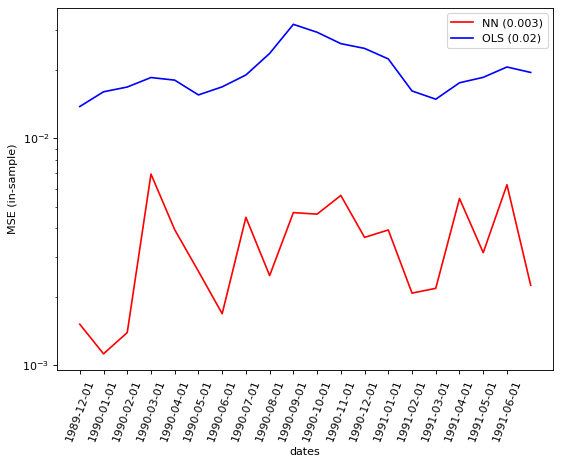

In [127]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
NN_label='NN (' + str(round(MSE_NN_in,3)) +')'
plt.plot(MSE_array_NN_in, color='red', label=NN_label)
plt.yscale('log')
OLS_label='OLS (' + str(round(MSE_linear_in,3)) +')'
plt.plot(MSE_array_linear_in, color='blue', label=OLS_label)
plt.ylabel('MSE (in-sample)')
plt.xlabel('dates')
plt.xticks(np.arange(0,len(dates)-1,1), dates, rotation=70)
plt.legend()
plt.savefig('MSE_in_error.eps', format='eps',dpi=1200,bbox_inches = "tight")

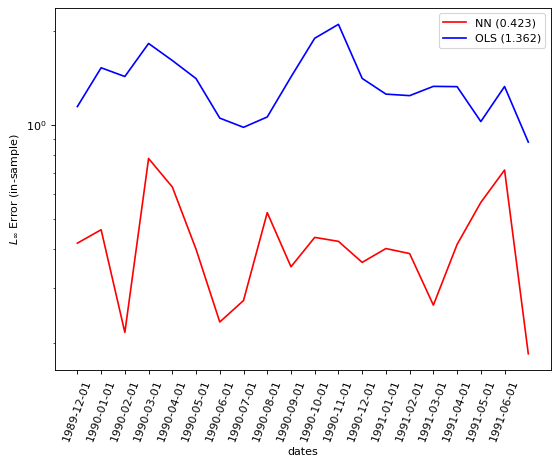

In [130]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
NN_label='NN (' + str(round(L_inf_NN_in,3)) +')'
plt.plot(L_inf_array_NN_in, color='red', label=NN_label)
plt.yscale('log')
OLS_label='OLS (' + str(round(L_inf_linear_in,3)) +')'
plt.plot(L_inf_array_linear_in, color='blue', label=OLS_label)
plt.ylabel('$L_{\infty}$ Error (in-sample)')
plt.xlabel('dates')
plt.xticks(np.arange(0,len(dates)-1,1), dates, rotation=70)
plt.legend()
plt.savefig('L_inf_in_error.eps', format='eps',dpi=1200,bbox_inches = "tight")

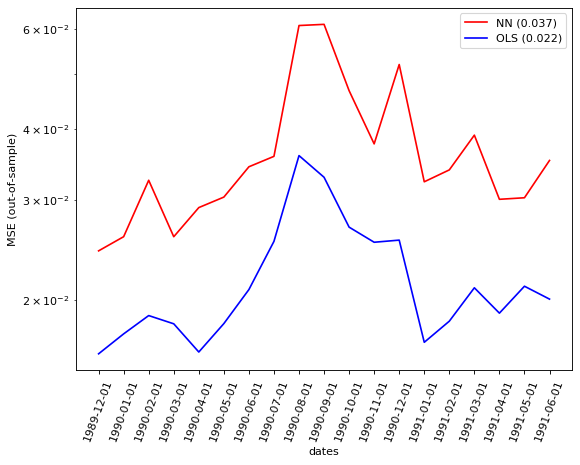

In [129]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
NN_label='NN (' + str(round(MSE_NN,3)) +')'
plt.plot(MSE_array_NN[:-1], color='red', label=NN_label)
plt.yscale('log')
OLS_label='OLS (' + str(round(MSE_linear,3)) +')'
plt.plot(MSE_array_linear[:-1], color='blue', label=OLS_label)
plt.ylabel('MSE (out-of-sample)')
plt.xlabel('dates')
plt.xticks(np.arange(0,len(dates)-1,1), dates, rotation=70)
plt.legend()
plt.savefig('MSE_error.eps', format='eps',dpi=1200,bbox_inches = "tight")

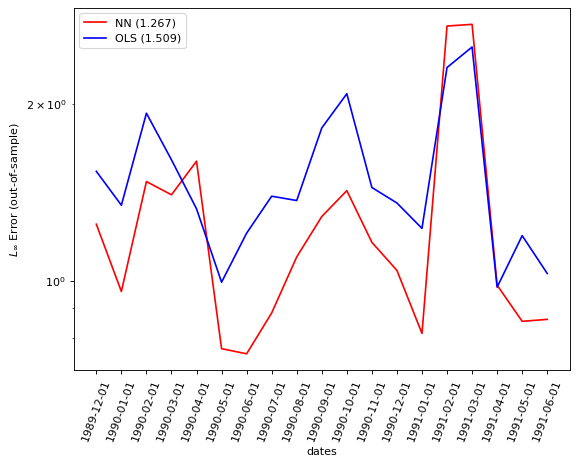

In [128]:
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
NN_label='NN (' + str(round(L_inf_NN,3)) +')'
plt.plot(L_inf_array_NN[:-1], color='red', label=NN_label)
plt.yscale('log')
OLS_label='OLS (' + str(round(L_inf_linear,3)) +')'
plt.plot(L_inf_array_linear[:-1], color='blue', label=OLS_label)
plt.ylabel('$L_{\infty}$ Error (out-of-sample)')
plt.xlabel('dates')
plt.xticks(np.arange(0,len(dates)-1,1), dates, rotation=70)
plt.legend()
plt.savefig('L_inf_error.eps', format='eps',dpi=1200,bbox_inches = "tight")

# Additional analysis of outliers

In [ ]:
# analysis with removal of outlier

In [62]:
outlier_index=np.argsort(MSE_array_linear)[328:330]

In [ ]:
# MSE without outliers

In [63]:
(np.sum(MSE_array_linear) - np.sum(MSE_array_linear[outlier_index]))/(testing_periods-2)

0.024346682165844864

In [ ]:
# L_inf without outliers

In [64]:
(np.sum(L_inf_array_linear) - np.sum(L_inf_array_linear[outlier_index]))/(testing_periods-2)

1.6866333874701676

In [ ]:
dates[outlier_index]

# Calculate information ratios

In [131]:
"""
 Information Ratio Calculation over most recent 10 year period
"""    

info_ratio = []
info_ratio_linear = []
info_ratio_NN = []
info_ratio_wn = []

m_range = [10,15,20,25,30,35,40,45,50]
for m in m_range:
    excess_returns_linear = []
    excess_returns_NN = []
    excess_returns_wn = []
    excess_returns_std_linear = []
    excess_returns_std_NN = []
    excess_returns_std_wn = []
    idx_linear = []
    idx_NN = []
    for i in range((testing_periods-120),testing_periods):
        idx_linear.append(np.argsort(-y_hat_linear[i].flatten())[:m])
        excess_returns_linear.append(np.mean(np.array(ys['test'][i])[idx_linear[-1]] ))
        
        idx_NN.append(np.argsort(-y_hat_NN[i].flatten())[:m])
        excess_returns_NN.append(np.mean(np.array(ys['test'][i])[idx_NN[-1]] ))
          
        #White Noise IR
        wn = np.asarray(random.sample(range(1, len(ys['test'][i])),m))
        excess_returns_wn.append(np.mean(np.array(ys['test'][i])[wn]))
        
    excess_returns_std_linear.append(np.std(excess_returns_linear))
    info_ratio_linear.append(np.mean(excess_returns_linear)/excess_returns_std_linear)
    
    excess_returns_std_NN.append(np.std(excess_returns_NN))
    info_ratio_NN.append(np.mean(excess_returns_NN)/excess_returns_std_NN)
      
    excess_returns_std_wn.append(np.std(excess_returns_wn))
    info_ratio_wn.append(np.mean(excess_returns_wn)/excess_returns_std_wn)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\kemen\anaconda3\envs\MLFenv\lib\site-packages\IPython\core\interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-131-331c64b886db>", line 21, in <module>
    idx_linear.append(np.argsort(-y_hat_linear[i].flatten())[:m])
IndexError: list index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\kemen\anaconda3\envs\MLFenv\lib\site-packages\IPython\core\interactiveshell.py", line 2044, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'IndexError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "C:\Users\kemen\anaconda3\envs\MLFenv\lib\site-packages\IPython\core\ultratb.py", line 1148, in get_records
    return _fixed_getinnerframes(etb, number_of_lines_of_conte

IndexError: list index out of range

In [ ]:
wn_label='Random (' + str(round(np.mean(info_ratio_wn),3)) + ')'
plt.plot(m_range, info_ratio_wn, label=wn_label, color='black')
OLS_label='OLS (' + str(round(np.mean(info_ratio_linear),3)) + ')'
plt.plot(m_range, info_ratio_linear, label=OLS_label, color='blue')
NN_label='NN (' + str(round(np.mean(info_ratio_NN),3)) + ')'
plt.plot(m_range, info_ratio_NN, label=NN_label, color='red')
#plt.plot(m_range, info_ratio_NN_relu, label='NN (ReLU 10)', color='red', linestyle='--')
plt.xlabel('Number of Stocks')
plt.ylabel('Information Ratio')
plt.legend()
plt.savefig('IR.eps', format='eps',dpi=1200,bbox_inches = "tight")

# Sector analysis

In [ ]:
"""
 Sector analysis over most recent 10 year period.
"""    


m_range = [50]

df_WN = pd.DataFrame(columns=['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9','S10'])
df_linear = pd.DataFrame(columns=['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9','S10'])
df_NN = pd.DataFrame(columns=['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9','S10'])


for m in m_range:
    idx_linear = []
    idx_NN = []
    idx_WN = []
    for i in range((testing_periods-120),testing_periods):
        idx_linear.append(np.argsort(-y_hat_linear[i].flatten())[:m])
        
        series=pd.Series(X[['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9','S10']].iloc[idx_linear[-1]].mean())
        df_linear=df_linear.append(series, ignore_index=True)
        
        
        idx_NN.append(np.argsort(-y_hat_NN[i].flatten())[:m])
        series=pd.Series(X[['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9','S10']].iloc[idx_NN[-1]].mean())
        df_NN=df_NN.append(series, ignore_index=True)
 
        #White Noise IR
        idx_WN.append(np.random.choice(np.arange(0,len(ys['test'][i])),m))
        series=pd.Series(X[['S0', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9','S10']].iloc[idx_WN[-1]].mean())
        df_WN=df_WN.append(series, ignore_index=True)

        

In [ ]:
GICS={'S0':'Energy','S1':'Materials','S2':'Industrials','S3':'Consumer Discretionary','S4':'Consumer Staples','S5':'Health Care','S6':'Financials','S7':'Information Technology','S8':'Communication Services','S9':'Utilities','S10':'Real Estate'}

In [ ]:
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

In [ ]:
rows=2
cols = 4
figsize=(10.5, 6)

sectors = ['S6','S3','S2','S9','S1','S4','S7','S5'] # ,'S0','S8']

fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(sectors))
for ax, sector in zip(axs, sectors):
    ax.set_title('%s' % str(GICS[sector]))
    #set(ax,'xtickl',get(ax,'xtick'))
    wn_label='Random: ' + str(round(np.mean(df_WN[sector]),3)) + ' (' + str(round(np.std(df_WN[sector]),3))  + ')'
    OLS_label='OLS: ' + str(round(np.mean(df_linear[sector]),3)) +  ' (' + str(round(np.std(df_linear[sector]),3)) + ')'
    NN_label='NN: ' + str(round(np.mean(df_NN[sector]),3)) +  ' (' + str(round(np.std(df_NN[sector]),3)) +  ')'
    
    ax.plot(range(0,len(df_NN)), df_NN[sector], 'o', ls='--', ms=4, color='red', label=NN_label)
    ax.plot(range(0,len(df_linear)), df_linear[sector], 'o', ls='--', ms=4, color='blue', label=OLS_label)
    #ax.plot(range(0,len(df_WN)), df_WN[sector], 'o', ls='--', ms=4, color='black', label=wn_label)
    
    #ax.xlabel('dates')
    #ax.set_xticklabels(np.arange(0,120,12), dates[np.arange(n-120,n,12)], rotation=70)
    fontdict= {'fontsize': 10,
    'fontweight': 1,
     'verticalalignment': 'baseline'}
    ax.set_ylim([np.min(df_NN[sector])-0.025,np.max(df_linear[sector])+0.15])
    ax.set_xticks(np.arange(0,120,12), minor=False)
    ax.set_xticklabels(dates[np.arange(n-120,n,12)], fontdict=fontdict) #, rotation=70)
    ax.tick_params(axis='x', rotation=70)
    ax.legend(loc='upper left')#, bbox_to_anchor=(1, 0.5))
    ax.axvline(x=93, linestyle='--', color='black')
fig1.tight_layout()
#plt.show()
plt.savefig('sector_tilts_hi.eps', format='eps',dpi=1200,bbox_inches = "tight")

In [ ]:
# show factor tilts on 2015-10-01 - the date of the outlier

In [ ]:
plt.plot(range(0,11),df_NN.iloc[93], color='red', label='NN')
plt.plot(range(0,11),df_linear.iloc[93], color='blue', label='OLS')
plt.xticks(range(0,11), [ GICS[sector] for sector in sectors ], rotation=70)
plt.legend()
plt.savefig('sector_tilts_2015-10-1.eps', format='eps',dpi=1200,bbox_inches = "tight")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
import pandas as pd
 
# Data
r = [0,1,2]

keys = df_WN.columns
raw_data = {}
for key in keys:
   raw_data[key]=[]
   raw_data[key].append(df_linear.mean()[key]) 
   raw_data[key].append(df_NN.mean()[key]) 
   raw_data[key].append(df_WN.mean()[key]) 

df = pd.DataFrame(raw_data)

In [ ]:
# From raw value to percentage
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
totals = [i+j+k+l+m+n+o+p+q+r+s for i,j,k,l,m,n,o,p,q,r,s in zip(df['S0'], df['S1'], df['S2'], df['S3'], df['S4'],df['S5'],df['S6'], df['S7'], df['S8'], df['S9'], df['S10'] )]
S0Bars = [i / j * 100 for i,j in zip(df['S0'], totals)]
S1Bars = [i / j * 100 for i,j in zip(df['S1'], totals)]
S2Bars = [i / j * 100 for i,j in zip(df['S2'], totals)]
S3Bars = [i / j * 100 for i,j in zip(df['S3'], totals)]
S4Bars = [i / j * 100 for i,j in zip(df['S4'], totals)]
S5Bars = [i / j * 100 for i,j in zip(df['S5'], totals)]
S6Bars = [i / j * 100 for i,j in zip(df['S6'], totals)]
S7Bars = [i / j * 100 for i,j in zip(df['S7'], totals)]
S8Bars = [i / j * 100 for i,j in zip(df['S8'], totals)]
S9Bars = [i / j * 100 for i,j in zip(df['S9'], totals)]
S10Bars = [i / j * 100 for i,j in zip(df['S10'], totals)]
 
# plot
barWidth = 0.85
names = ('DNN','Linear','Universe')
# Create green Bars
plt.bar(r, S0Bars, color='#b5ffb9', edgecolor='white', width=barWidth, label=GICS['S0'])
# Create orange Bars
plt.bar(r, S1Bars, bottom=S0Bars, color='#f9bc86', edgecolor='white', width=barWidth, label=GICS['S1'])
# Create blue Bars
plt.bar(r, S2Bars, bottom=[i+j for i,j in zip(S0Bars, S1Bars)], color='#a3acff', edgecolor='white', width=barWidth, label=GICS['S2'])
# Create blue Bars
plt.bar(r, S3Bars, bottom=[i+j+k for i,j,k in zip(S0Bars, S1Bars, S2Bars)], color='#5b3475', edgecolor='white', width=barWidth, label=GICS['S3'])
# Create blue Bars
plt.bar(r, S4Bars, bottom=[i+j+k+l for i,j,k,l in zip(S0Bars, S1Bars, S2Bars, S3Bars)], color='#e80027', edgecolor='white', width=barWidth, label=GICS['S4'])
# Create blue Bars
plt.bar(r, S5Bars, bottom=[i+j+k+l+m for i,j,k,l,m in zip(S0Bars, S1Bars, S2Bars, S3Bars, S4Bars)], color='#471e02', edgecolor='white', width=barWidth, label=GICS['S5'])
# Create blue Bars
plt.bar(r, S6Bars, bottom=[i+j+k+l+m+n for i,j,k,l,m,n in zip(S0Bars, S1Bars, S2Bars, S3Bars, S4Bars, S5Bars)], color='#f40088', edgecolor='white', width=barWidth, label=GICS['S6'])
# Create blue Bars
plt.bar(r, S7Bars, bottom=[i+j+k+l+m+n+o for i,j,k,l,m,n,o in zip(S0Bars, S1Bars, S2Bars, S3Bars, S4Bars, S5Bars,S6Bars)], color='#c9f7ca', edgecolor='white', width=barWidth, label=GICS['S7'])
# Create blue Bars
plt.bar(r, S8Bars, bottom=[i+j+k+l+m+n+o+p for i,j,k,l,m,n,o,p in zip(S0Bars, S1Bars, S2Bars, S3Bars, S4Bars, S5Bars,S6Bars,S7Bars)], color='#ca642d', edgecolor='white', width=barWidth, label=GICS['S8'])
# Create blue Bars
plt.bar(r, S9Bars, bottom=[i+j+k+l+m+n+o+p+q for i,j,k,l,m,n,o,p,q in zip(S0Bars, S1Bars, S2Bars, S3Bars, S4Bars, S5Bars,S6Bars,S7Bars,S8Bars)], color='#295151', edgecolor='white', width=barWidth, label=GICS['S9'])

plt.bar(r, S10Bars, bottom=[i+j+k+l+m+n+o+p+q+r for i,j,k,l,m,n,o,p,q,r in zip(S0Bars, S1Bars, S2Bars, S3Bars, S4Bars, S5Bars,S6Bars,S7Bars,S8Bars,S9Bars)], color='#a3ff00', edgecolor='white', width=barWidth, label=GICS['S10'])

    
# Custom x axis
plt.xticks(r, names)
#plt.xlabel("group")
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

# Show graphic
#plt.show()
plt.savefig('sectors.png', format='png',dpi=1200)#,bbox_inches = "tight")

# factor analysis

In [ ]:
"""
 factor analysis over most recent 10 year period.
"""    


m_range = [50]
columns=['F1', 'F2', 'F3', 'F5', 'F6', 'F7','F8', 'F9', 'F12', 'F13', 'F14',
       'F16', 'F17','F18']
df_WN = pd.DataFrame(columns=columns)
df_linear = pd.DataFrame(columns=columns)
df_NN = pd.DataFrame(columns=columns)


for m in m_range:
    idx_linear = []
    idx_NN = []
    idx_WN = []
    for i in range((testing_periods-120),testing_periods):
        idx_linear.append(np.argsort(-y_hat_linear[i].flatten())[:m])
        
        series=pd.Series(X[columns].iloc[idx_linear[-1]].mean())
        df_linear=df_linear.append(series, ignore_index=True)
        
        
        idx_NN.append(np.argsort(-y_hat_NN[i].flatten())[:m])
        series=pd.Series(X[columns].iloc[idx_NN[-1]].mean())
        df_NN=df_NN.append(series, ignore_index=True)
 
        #White Noise IR
        idx_WN.append(np.random.choice(np.arange(0,len(ys['test'][i])),m))
        series=pd.Series(X[columns].iloc[idx_WN[-1]].mean())
        df_WN=df_WN.append(series, ignore_index=True)


In [ ]:
# show factor tilts on 2015-10-01 - the date of the outlier

In [ ]:
names={'F1':'B/P', 'F2':'CF/P', 'F3':'E/P', 'F4':'S/EV', 'F5':'EB/EV', 'F6':'FE/P', 'F7':'TAG', 'F8':'MC', 'F9':'S', 'F10':'TA', 'F11':'TrA', 'F12':'EaV/TA', 'F13':'CFV/TA', 'F14':'SV/TA','F15':'RV', 'F16':'CB','F17':'Div', 'F18':'EG'}

In [ ]:
full_names={'F1':'Book to Price (B/P)', 'F2': 'Cash Flow to Price (CF/P)', 'F3':'Earning to Price (E/P)', 'F5': 'EBIDTA to EV (EB/EV)', 'F7': 'Total Asset Growth (TAG)', 'F13':'Cash Flow Volatility to Total Assets (CFV/TA)', 'F14':'Sales Volatility to Total Assets (SV/TA)', 'F16': 'Rolling CAPM Beta (CB)'}

In [ ]:
plt.plot(range(0,14),df_NN.iloc[93], color='red', label='NN')
plt.plot(range(0,14),df_linear.iloc[93], color='blue', label='OLS')
plt.xticks(range(0,14), [ names[column] for column in columns ], rotation=70)
plt.legend()
plt.savefig('factor_tilts_2015-10-1.eps', format='eps',dpi=1200,bbox_inches = "tight")

In [ ]:
rows=2
cols = 4
figsize=(13.7, 6)
# plot a subset of factors
factors=['F1', 'F2', 'F3', 'F5',  'F7', 'F13', 'F14',
       'F16']
#factors=columns #uncomment for all factors
fig1, axs = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
axs = trim_axs(axs, len(factors))
for ax, factor in zip(axs, factors):
    ax.set_title('%s' % str(full_names[factor]))
    #set(ax,'xtickl',get(ax,'xtick'))
    wn_label='Random: ' + str(round(np.mean(df_WN[factor]),3)) + ' (' + str(round(np.std(df_WN[factor]),3))  + ')'
    OLS_label='OLS: ' + str(round(np.mean(df_linear[factor]),3)) +  ' (' + str(round(np.std(df_linear[factor]),3)) + ')'
    NN_label='NN: ' + str(round(np.mean(df_NN[factor]),3)) +  ' (' + str(round(np.std(df_NN[factor]),3)) +  ')'
    
    ax.plot(range(0,len(df_NN)), df_NN[factor], 'o', ls='--', ms=4, color='red', label=NN_label)
    ax.plot(range(0,len(df_linear)), df_linear[factor], 'o', ls='--', ms=4, color='blue', label=OLS_label)
    #ax.plot(range(0,len(df_WN)), df_WN[sector], 'o', ls='--', ms=4, color='black', label=wn_label)
    
    #ax.xlabel('dates')
    #ax.set_xticklabels(np.arange(0,120,12), dates[np.arange(n-120,n,12)], rotation=70)
    fontdict= {'fontsize': 10,
    'fontweight': 1,
     'verticalalignment': 'baseline'}
    ax.set_ylim([np.min(df_NN[factor])-0.25,np.max(df_linear[factor])+0.65])
    ax.set_xticks(np.arange(0,120,12), minor=False)
    ax.set_xticklabels(dates[np.arange(n-120,n,12)], fontdict=fontdict) #, rotation=70)
    ax.tick_params(axis='x', rotation=70)
    ax.axvline(x=93, linestyle='--', color='black')
    ax.legend(loc='upper left')#, bbox_to_anchor=(1, 0.5))
fig1.tight_layout()
plt.savefig('factors_tilts_hi.eps', format='eps',dpi=1200,bbox_inches = "tight")